### A quick and dirty Twitter app
- This is my first Twitter app, and I only looked this up a couple hours ago, so bare with me...
- (I don't even Tweet)
- install the Twitter pyAPI:
    - pip install python-twitter
- go to apps.twitter.com and "create a new application"
    - from this, collect all the api_id data (authentication, etc.)
	    - How much of this are we really supposed to keep secret?
- Then, we'll just demo some simple functionality
    - Get a twitter-feed sample
	- Look for recurring words, maybe word-pairs, etc.

#### Some things we find:
- Unless you are highly multi-lingual, this might be a bit limited. we could maybe use some Google Translate
- ... but be really careful with the word-pairs (sequential words), since word sequencing does not mean the same thing in all languages (aka, in latin and I think Germanic languages, order is important, but in Russian and other Slavic languages, not so much...
- maybe use a dictionary of English words to filter out non-English data? maybe geo-locate?

##### Security comment:
- I do not quite understand how 'secret' the secret authentication keys for this app are supposed to be, so for the time being, i'm not going to provide the consumer_secret, etc. keys (i assume these are encryption key paris).
- So, to actually run this code, you'll need to get your own keys and either code them directly into the notebook or code them into a .json file (format should be easy enough to infer from code).
- See above commentary to get your own twitter applicaiton id keys.


In [7]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
#
import numpy
import scipy
import pylab as plt
import sklearn
import pandas
import random

import datetime as dtm
import matplotlib.dates as mpd

import os
import sys
#
import twitter
import json

punctuations = ['.', ',', ':', '/', '(', ')', '-'] #... and others

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%%javascript

    // apply setting to all current CodeMirror instances
    IPython.notebook.get_cells().map(
        function(c) {  return c.code_mirror.options.indentWithTabs=true;  }
    );

    // make sure new CodeMirror instances created in the future also use this setting
    CodeMirror.defaults.indentWithTabs=true;

<IPython.core.display.Javascript object>

In [9]:
with open('twitter_secrets.json', 'r') as fin:
	tw_datas = json.load(fin)

In [10]:
my_app_data = tw_datas['yoda_dev'] 
mad = my_app_data
api = twitter.Api(consumer_key=mad['api_key'], consumer_secret=mad['api_secret'], 
				  access_token_key=mad['access_token'], 
				  access_token_secret=mad['access_token_secret'])


In [11]:
api.GetUser(screen_name='markyoder')

User(ID=48048726, ScreenName=markyoder)

In [16]:
tweets = []
words = []
# Note: this takes quite a while for N=10000; time to come up with a parallelization strategy?
#
n_tweets = 10000
for j, twt in enumerate(api.GetStreamSample()):
	#
	#print('**DEBUG: [{}]'.format(j))
	#if j>100: break
	if len(tweets)>=n_tweets: break
	#
	if not 'text' in twt.keys():
		 # other exception handling?
		continue
	#
	tweets += [twt]
	txt = twt['text']
	for p in punctuations:
		txt = txt.replace(p,'')
	words += txt.split()
	#
	#print('tweet[{}]:: {}\n'.format(j, json.dumps(twt)))
	if len(tweets)%(int(.1*n_tweets))==0: print('tweet[{}]'.format(len(tweets)))
#
print('finished collecting tweets')
#

finished collecting tweets


#### (Unique) Word Count
- How many words in this set of tweets?
- How many unique words?
- Most popular words? Distribution of word counts?

counts: 47617(47617)/102255
most popular words: 
[0]:: (4849) : RT
[1]:: (967) : a
[2]:: (825) : to
[3]:: (750) : the
[4]:: (549) : I
[5]:: (544) : de
[6]:: (479) : you
[7]:: (457) : and
[8]:: (397) : of
[9]:: (396) : is
[10]:: (375) : for


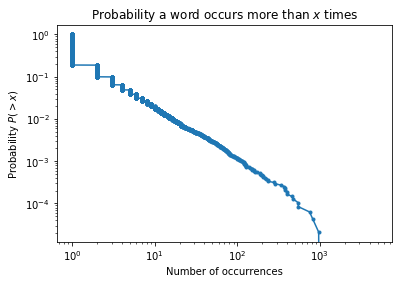

In [17]:
# this is still a little redundant and can be streamlined a bit, but it illustrates how to use
# different data types to get unique data sets, etc.
#
class Word_analyzer(object):
	def __init__(self, words):
		s_words = set(words)
		n_words = len(words)
		n_unique_words = len(s_words)
		unique_words = {wrd:words.count(wrd) for wrd in set(s_words)}
		#
		# this should be a faster way to compute the word-count:
		unique_words2 = {wrd:0 for wrd in s_words}
		for wrd in words: unique_words2[wrd]+=1
		#

		print('counts: {}({})/{}'.format(n_unique_words, len(unique_words2), n_words))
		#
		print('most popular words: ')
		j=0
		for (wrd,n) in sorted(unique_words.items(), key=lambda rw:rw[1])[::-1]:
			print('[{}]:: ({}) : {}'.format(j, n, wrd))
			if j>=10: break
			j+=1
		#
		plt.figure()
		plt.clf()
		ax=plt.gca()
		wrds, x_axis = numpy.array(sorted(unique_words.items(), key=lambda rw:rw[1])[::-1]).T
		ax.plot(x_axis, numpy.linspace(0,1,len(x_axis)), marker='.', ls='-')
		ax.set_title('Probability a word occurs more than $x$ times')
		ax.set_ylabel('Probability $P(>x)$')
		ax.set_xlabel('Number of occurrences')
		#
		ax.set_xscale('log')
		ax.set_yscale('log')
		#
		# add all these variables to 'self':
		self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
#
singles = Word_analyzer(words)

### Word Pairs
- Nominally, we create word pairs by just concatenating our words array
- ... except that this joins word pairs from subsequent tweets.  this might be an acceptable error...
- ... but we should collect word-pairs at the individual tweet level, so we'll want to re-spin the tweets array.


In [18]:
word_pairs = []
for twt in tweets:
	txt = twt['text']
	for p in punctuations:
		txt = txt.replace(p,'')
	#
	word_pairs += ['{} {}'.format(w1, w2) for w1, w2 in zip(txt.split()[0:-1], txt.split()[1:])]
#print('wp: ', word_pairs[50:55])

counts: 73905(73905)/92255
most popular words: 
[0]:: (77) : #MTVHottest Lady
[1]:: (77) : Lady Gaga
[2]:: (58) : سبحان الله
[3]:: (56) : إله إلا
[4]:: (55) : ㅤ ㅤ
[5]:: (53) : لا إله
[6]:: (52) : in the
[7]:: (51) : of the
[8]:: (50) : for the
[9]:: (50) : to be
[10]:: (48) : اللهم إني


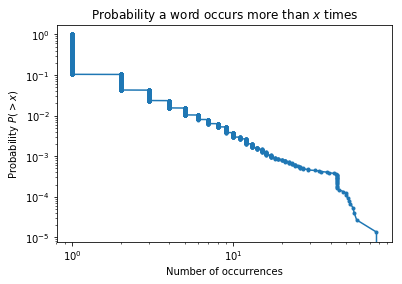

In [19]:
doubles = Word_analyzer(word_pairs)

#### More on unique words...
- Even for single word frequency, maybe it makes more sense to consider frequency per tweet...
- ... but we'll need to think more carefully about what this means, and what we're looking for from it.
- mean number of occurrences per tweet? we can just divide by the number of tweets, and this should be about right.
- one thing we might do is to construct input vectors for some expected event or condition (aka, rate of tweets containing some set of words)